# Analyses of adversarial scenarios

In [1]:
require(data.table)
require(ggplot2)
require(magrittr)

Loading required package: data.table

Loading required package: ggplot2

Loading required package: magrittr



## No honest quorum in round

In [2]:
prob <- function(f, C)
  pnorm(f, 1 / 4, sqrt((1 - f) / C))

In [3]:
result <-
  CJ(f=0:250/1000, C=1:100*10)[,
    .(f, C, P=prob(f, C))
  ]

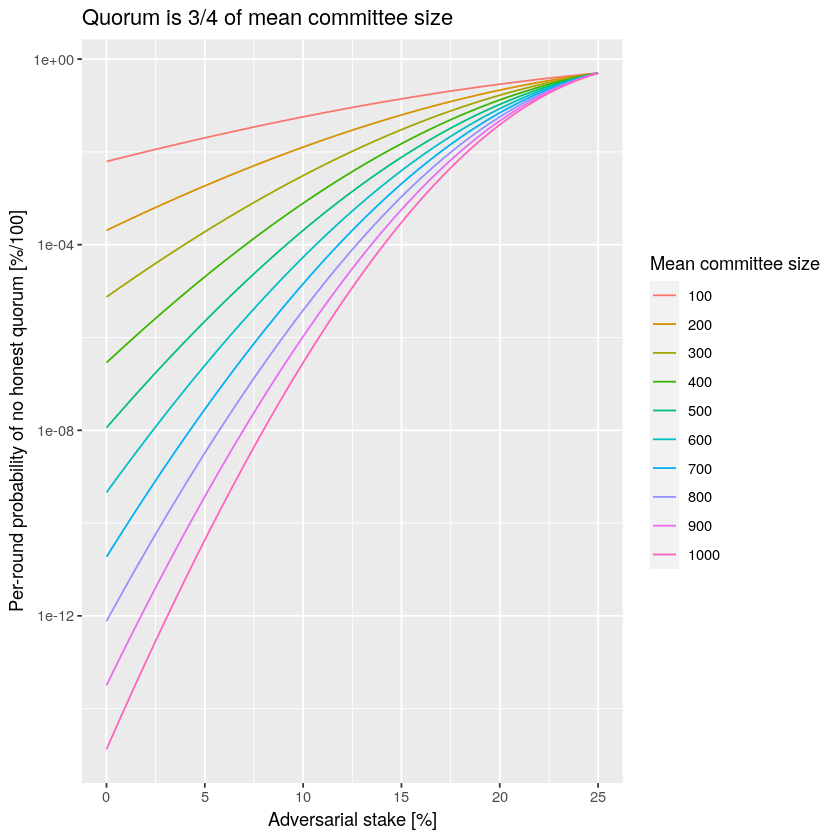

In [4]:
ggplot(result[`C` %in% (1:10*100)], aes(x=100*f, y=P, color=factor(C))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial stake [%]") +
  ylab("Per-round probability of no honest quorum [%/100]") +
  guides(color=guide_legend(title="Mean committee size")) +
  ggtitle("Quorum is 3/4 of mean committee size")

In [5]:
ggsave(file="no-honest-quorum.plot.png", width=6, height=4, units="in", dpi=150)

## Adversarial quorum

In [6]:
prob <- function(f, C)
  pnorm(f, 3 / 4, sqrt(f / C))

In [7]:
result <-
  CJ(f=0:250/1000, C=1:100*10)[,
    .(f, C, P=prob(f, C))
  ]

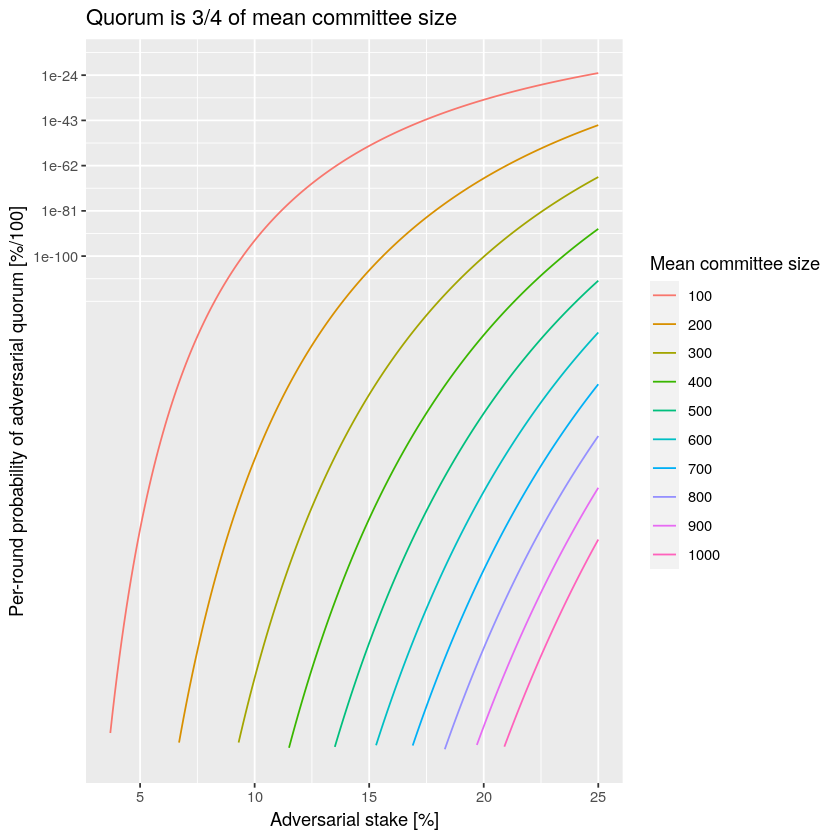

In [8]:
ggplot(result[`C` %in% (1:10*100)][P > 0], aes(x=100*f, y=P, color=factor(C))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial stake [%]") +
  ylab("Per-round probability of adversarial quorum [%/100]") +
  guides(color=guide_legend(title="Mean committee size")) +
  ggtitle("Quorum is 3/4 of mean committee size")

In [9]:
ggsave(file="adversarial-quorum.plot.png", width=6, height=4, units="in", dpi=150)

## No certificate in honest block

In [10]:
prob <- function(A, f, alpha)
  (1 - alpha)^((1 - f) * A)

In [11]:
result <-
  CJ(alpha=0.05, f=0:250/1000, A=1:80*10)[, 
    .(alpha, f, A, P=prob(A, f, alpha))
  ]

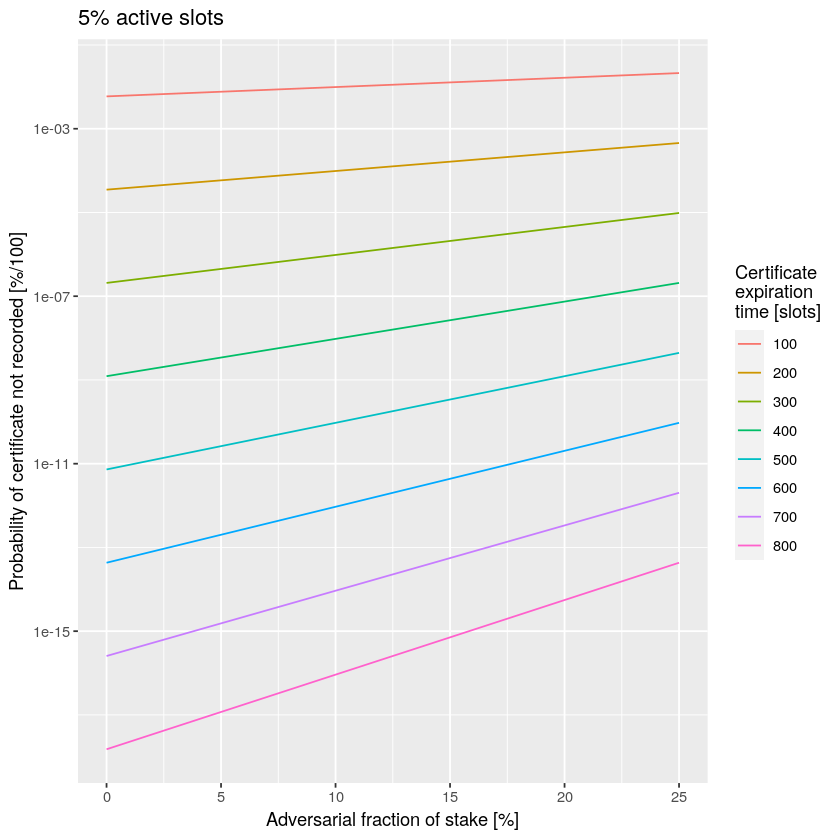

In [12]:
ggplot(result[`A` %in% (1:8*100)], aes(x=100*f, y=P, color=factor(A))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Probability of certificate not recorded [%/100]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(color=guide_legend(title="Certificate\nexpiration\ntime [slots]"))

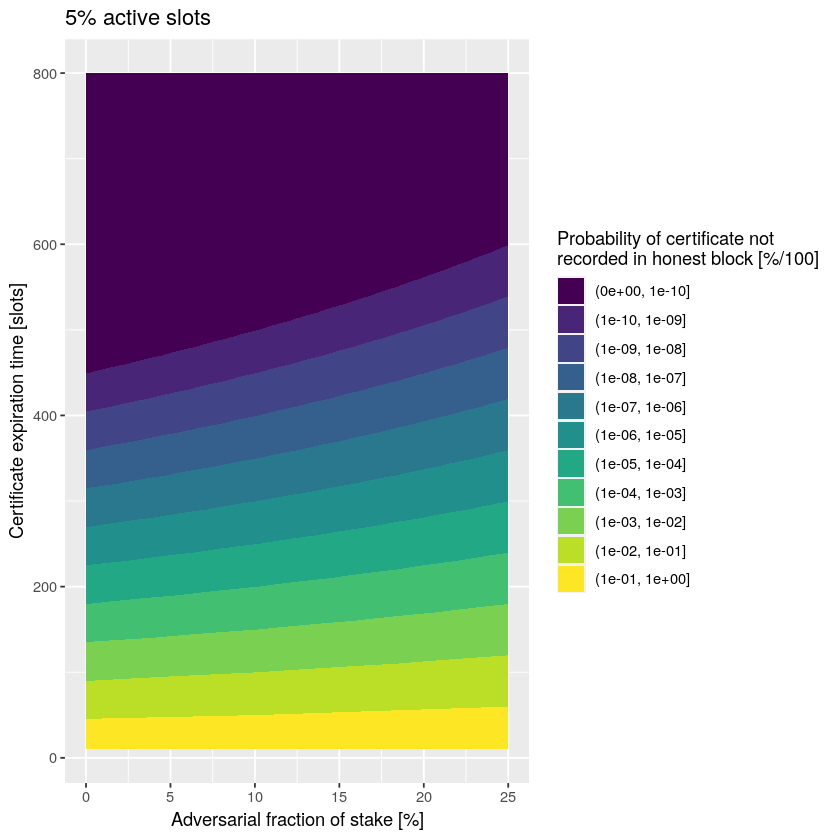

In [13]:
ggplot(result, aes(x=100*f, y=A, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Certificate expiration time [slots]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Probability of certificate not\nrecorded in honest block [%/100]"))

In [14]:
ggsave(file="no-certificate-in-honest-block.plot.png", width=6, height=4, units="in", dpi=150)

## Adversarial chain receives boost

### Variant 1

In [15]:
prob <- function(U, p, q)
    sum( pbinom(1:U-1, U, p) * dbinom(1:U, U, q) )

In [16]:
result <-
  CJ(alpha=0.05, U=seq(30, 1200, 10), f=seq(0, 0.5, 0.005))[, 
    .(alpha, U, f, p=alpha*(1-f), q=alpha*f)
  ][,
    .(alpha, U, f, p, q, P=mapply(prob,U,p,q))
  ]

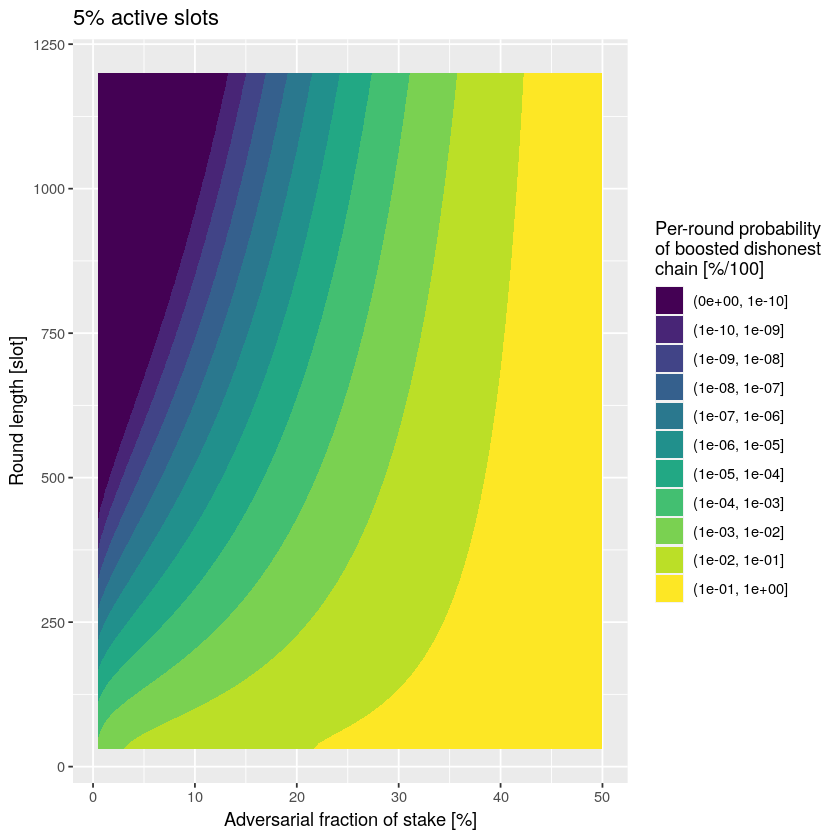

In [17]:
ggplot(result[P > 0], aes(x=100*f, y=U, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Round length [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Per-round probability\nof boosted dishonest\nchain [%/100]"))

In [18]:
ggsave(file="adversarial-chain-receives-boost.plot.png", width=6, height=4, units="in", dpi=150)

Check against the equivalent Haskell simulation.

```haskell
sum $ Map.elems $ Map.filterWithKey (\(m,n) _ -> m < n) $ lengths transitions (3 / 80) (1 / 80) 150 separatedChains def
```
```console
5.070766904212096e-2
```

In [19]:
prob(150, 3/80, 1/80)

[1] 0.05070767

### Variant 2

In [20]:
prob <- function (U, p, q) {
  f <- q / (p + q)
  p0 <- (1 - f) * sum( pbinom(0:(U-1), U, p) * dbinom(1:U, U, q) )
  pk <- (1 - f) * sum( mapply(function(k) f^k * sum( pbinom((k-1):(U-1), U, p) * dbinom(0:(U-k), U, q) ), 1:U) )
  pinf <- f^(U+1)
  p0 + pk + pinf
}

In [21]:
result <-
  CJ(alpha=0.05, U=seq(30, 1200, 10), f=seq(0, 0.5, 0.005))[,
    .(alpha, U, f, p=alpha*(1-f), q=alpha*f)
  ][, 
    .(alpha, U, f, p, q, P=mapply(prob,U,p,q))
  ]

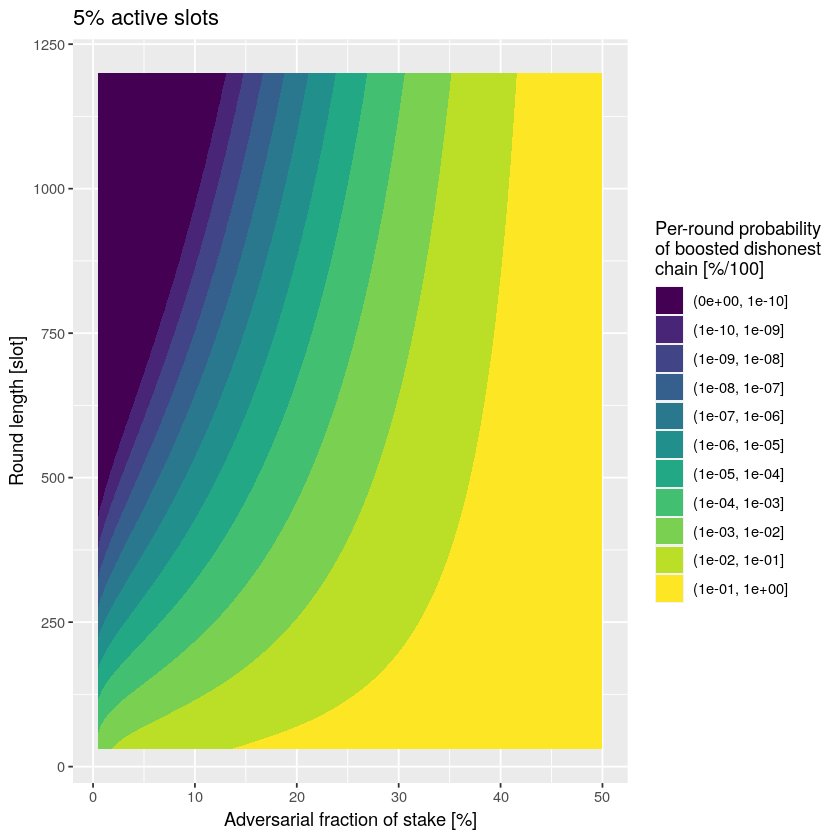

In [22]:
ggplot(result[P > 0], aes(x=100*f, y=U, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Round length [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Per-round probability\nof boosted dishonest\nchain [%/100]"))

In [23]:
ggsave(file="adversarial-chain-receives-boost-variant.plot.png", width=6, height=4, units="in", dpi=150)

Check against a brute-force computation.

In [24]:
probRef <- function (U, p, q) {
    z <- (q / (p + q))^(U+1)
    for (m in 0:U)
        for (n in 0:U)
            for (k in 0:U)
                if (m < n + k && n + k <= U)
                    z <- z + dbinom(m, U, p) * dbinom(n, U, q) * p / (p + q) * (q / (p + q))^k
    z
}

In [25]:
probRef(150, 3/80, 1/80)

[1] 0.07358321

In [26]:
prob(150, 3 / 80, 1 / 80)

[1] 0.07358321

Check against the equivalent Haskell simulation.

```haskell
z = transitions (3 / 80) (1 / 80) 150 separatedChains def
sum [ (3/4) * (1/4)^(fromIntegral k) * sum (Map.elems $ Map.filterWithKey (\(m,n) _ -> m < k + n) $ lengths z) | k <- [0..30]]

7.358321238867102e-2
```

## Healing from adversarial boost

In [27]:
prob <- function(s, B, p, q)
  1 - sum(dbinom(B:s, s, p) * pbinom(B:s-B, s, q))

In [28]:
prob <- function(s, B, p, q)
  sum(pbinom((B-1):s, s, p) * dbinom(0:(s-B+1), s, q))

In [29]:
prob <- function(s, B, p, q)
  sum(pbinom((B-1):(s+B-1), s, p) * dbinom(0:s, s, q))

In [30]:
result <-
  CJ(alpha=0.05, s=seq(1000, 10000, 100), B=c(1, 3, 10, 20, 50, 100), f=seq(0, 0.5, 0.005))[,
    .(alpha, s, B, f, p=alpha*(1-f), q=alpha*f)
  ][, 
    .(alpha, s, B, f, p, q, P=mapply(prob,s,B,p,q), Blabel=factor(paste("B", B, sep="="), levels=c("B=1", "B=3", "B=10", "B=20", "B=50", "B=100")))
  ]

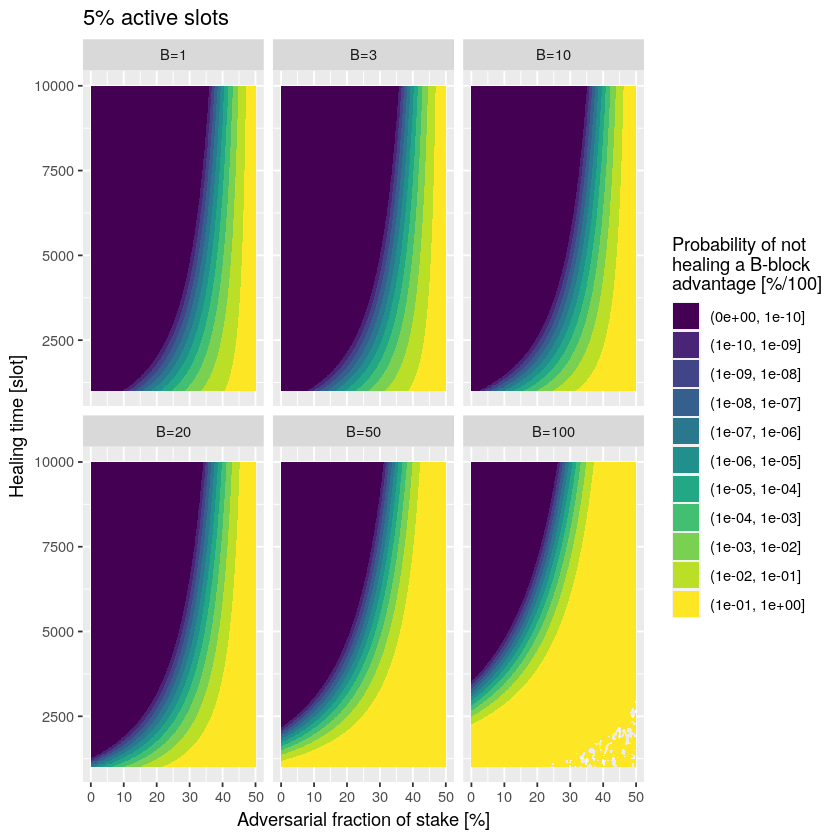

In [31]:
ggplot(result, aes(x=100*f, y=s, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  facet_wrap(. ~ Blabel) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Healing time [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Probability of not\nhealing a B-block\nadvantage [%/100]"))

In [32]:
ggsave(file="healing-from-adversarial-boost.plot.png", width=6, height=4, units="in", dpi=150)

## No honest block

In [33]:
prob <- function(s, f, alpha)
  (1 - alpha)^((1 - f) * s)

In [34]:
result <-
  CJ(alpha=0.05, f=0:250/1000, s=1:80*10)[, 
    .(alpha, f, s, P=prob(s, f, alpha))
  ]

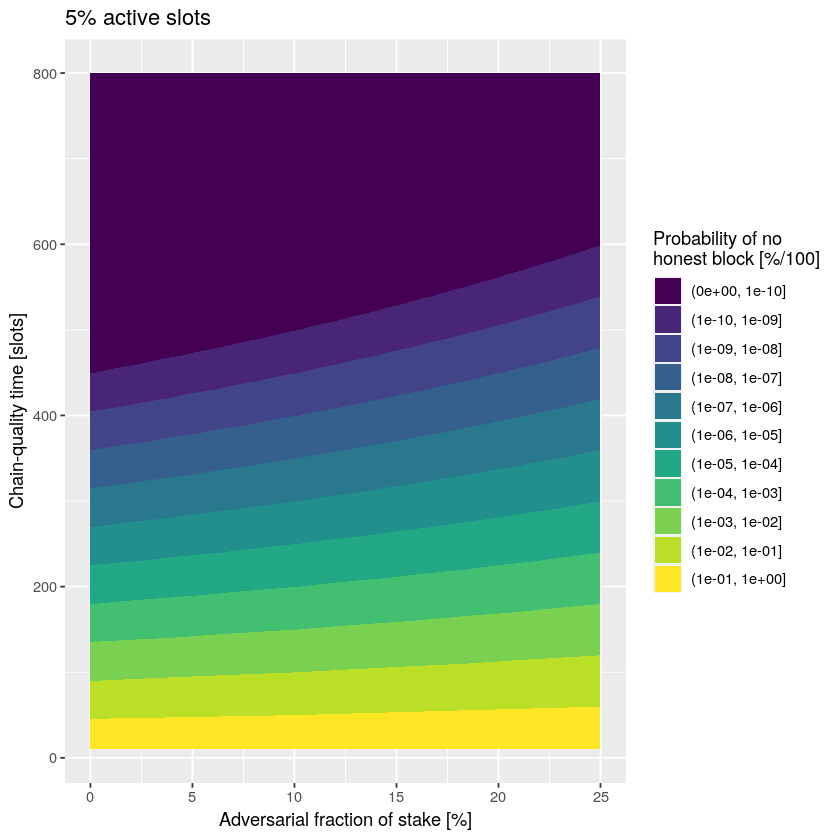

In [35]:
ggplot(result, aes(x=100*f, y=s, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Chain-quality time [slots]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Probability of no\nhonest block [%/100]"))

In [36]:
ggsave(file="no-honest-block.plot.png", width=6, height=4, units="in", dpi=150)

## Double spend

In [37]:
prob <- function(z, f)
    1 - (pnbinom(z - 1, z, 1 - f) - pnbinom(z - 1, z, f))

In [38]:
result <-
  CJ(z=seq(10, 2000, 10), f=seq(0.005, 0.5, 0.005))[, 
    .(z, f, P=mapply(prob,z,f))
  ]

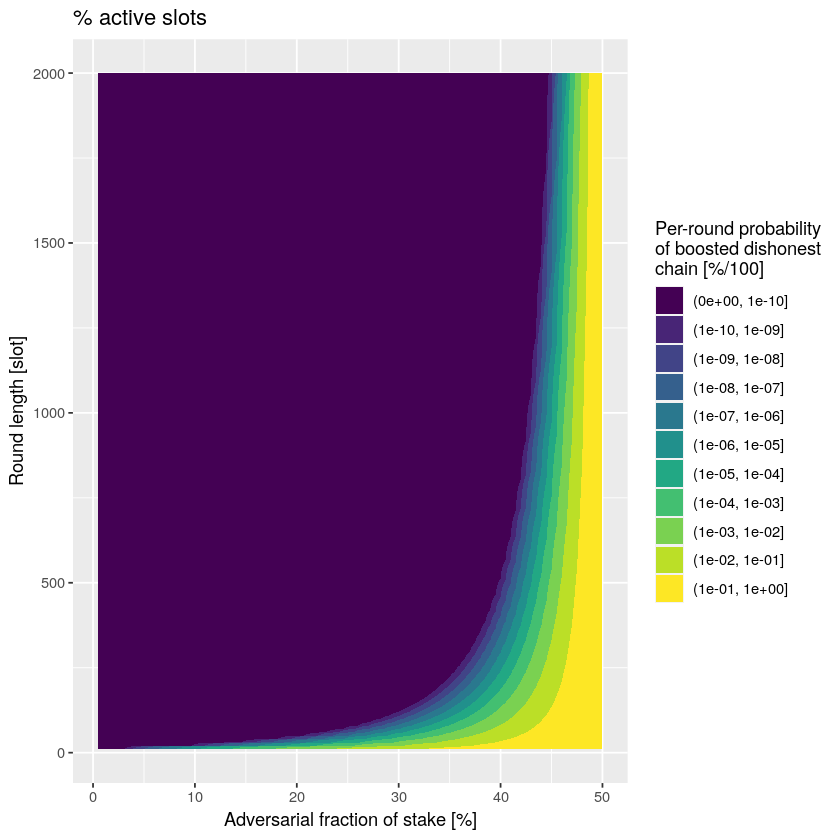

In [39]:
ggplot(result, aes(x=100*f, y=z, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Round length [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Per-round probability\nof boosted dishonest\nchain [%/100]"))

In [40]:
result <-
  CJ(z=seq(10, 2000, 10), f=seq(0.005, 0.5, 0.005))[, 
    .(z, f, P=mapply(prob,z,f))
  ]

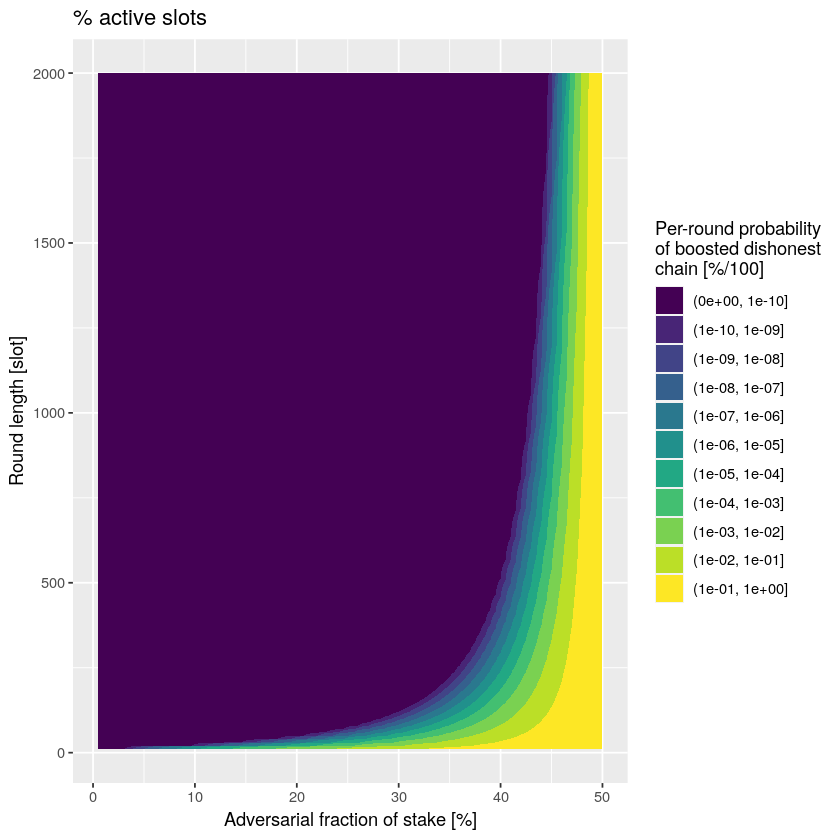

In [41]:
ggplot(result, aes(x=100*f, y=z, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Round length [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Per-round probability\nof boosted dishonest\nchain [%/100]"))

## No common prefix

In [42]:
prob <- function(s, p, q)
  sum(pbinom(0:s, s, p) * dbinom(0:s, s, q))

In [43]:
result <-
  CJ(alpha=0.05, s=seq(1000, 20000, 100), f=seq(0, 0.5, 0.005))[,
    .(alpha, s, f, p=alpha*(1-f), q=alpha*f)
  ][, 
    .(alpha, s, f, p, q, P=mapply(prob,s,p,q))
  ]

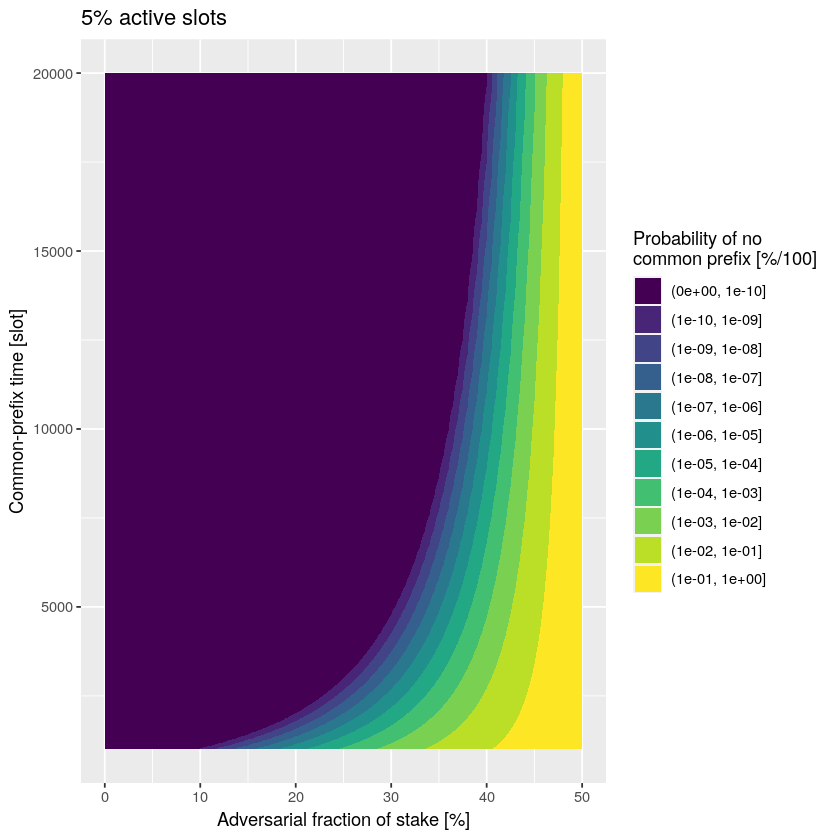

In [44]:
ggplot(result, aes(x=100*f, y=s, z=P)) +
  geom_contour_filled(breaks=c(0,10^(-(10:0)))) +
  xlab("Adversarial fraction of stake [%]") +
  ylab("Common-prefix time [slot]") +
  ggtitle(paste(100 * unique(result$alpha), "% active slots", sep="")) +
  guides(fill=guide_legend(title="Probability of no\ncommon prefix [%/100]"))

In [45]:
ggsave(file="no-common-prefix.plot.png", width=6, height=4, units="in", dpi=150)

## Work in progress

In [46]:
prob <- function(z, f)
  1 - sum( mapply(function(k) ((1 - f)^z * f^k - f^z * (1 - f)^k) * choose(k + z - 1, k), 0:(z-1)) )

In [47]:
prob(10, 1/4)

[1] 0.01780656

In [48]:
prob(100, 3/8)

[1] 0.0003328853

In [49]:
prob(500, 2/8)

[1] -2.220446e-15

In [50]:
prob <- function(z, f)
  1 - sum( mapply(function(k) (dnbinom(k,z,1-f) - dnbinom(k,z,f)), 0:(z-1)) )

In [51]:
prob(10, 1/4)

[1] 0.01780656

In [52]:
prob(100, 3/8)

[1] 0.0003328853

In [53]:
prob(500, 2/8)

[1] 2.220446e-16

In [54]:
prob <- function(z, f)
  (1 - pnbinom(z-1,z,1-f)) + pnbinom(z-1,z,f)

In [55]:
prob(10, 1/4)

[1] 0.01780656

In [56]:
prob(100, 3/8)

[1] 0.0003328853

In [57]:
prob(500, 2/8)

[1] 8.53439e-65

In [58]:
prob(500, 0.49)

[1] 0.5271512

In [59]:
prob(2000, 0.49)

[1] 0.2058862

In [60]:
prob <- function(z, f)
  c(1 - pnbinom(z-1,z,1-f), pnbinom(z-1,z,f))

In [61]:
prob(10, 1/4)

[1] 0.008903279 0.008903279

In [62]:
prob(100, 3/8)

[1] 0.0001664426 0.0001664426

In [63]:
prob(500, 2/8)

[1] 0.00000e+00 8.53439e-65

In [64]:
prob(500, 0.49)

[1] 0.2635756 0.2635756

In [65]:
prob(2000, 0.49)

[1] 0.1029431 0.1029431

In [66]:
prob <- function(z, f)
  (1 - pnbinom(z-1,z,1-f)) + (1 - pnbinom(z-1,z,f))

In [67]:
prob(10, 1/4)

[1] 1

In [68]:
prob(100, 3/8)

[1] 1

In [69]:
prob(500, 2/8)

[1] 1

In [70]:
prob(500, 0.49)

[1] 1

In [71]:
prob(2000, 0.49)

[1] 1